# Inicializálás

In [1]:
%cd SelectiveForgetting

/home/bbea/unlearn/SelectiveForgetting


In [2]:
import sys
sys.path.append('/home/bbea/unlearning/SelectiveForgetting/')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
import numpy as np
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import models
import datasets
from utils import *

/home/bbea/miniconda3/envs/unlearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def pdb():
    import pdb
    pdb.set_trace

def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

# Modell betanítása

In [5]:
numf = 100

CIFAR10-en az eredeti

In [6]:
train_time_o = 0
train_time_ft = 0
train_time_f = 0
train_time_r = 0

In [7]:
tic = time.perf_counter()

In [8]:
#%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.1 --lossfn ce --num-classes 10 --batch-size 128 --weight-decay 0.001
#875,607s

In [9]:
toc = time.perf_counter()
train_time_o += (toc - tic)
train_time_ft += (toc - tic)
train_time_f += (toc - tic)

Elfeledtetendő adatok megjelölése és fine-tuning

In [10]:
tic = time.perf_counter()

In [11]:
%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.0001\
--resume checkpoints/cifar10_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1_30_original.pt --disable-bn\
--weight-decay 0.001 --batch-size 128 --epochs 15 --seed 1 --forget-class 0 --num-to-forget 100
#29,068s

Checkpoint name: cifar10_resnet_0_4_forget_0_num_100_lr_0_0001_bs_128_ls_ce_wd_0_001_seed_1
[Logging in cifar10_resnet_0_4_forget_0_num_100_lr_0_0001_bs_128_ls_ce_wd_0_001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255]
Number of Classes: 10
[0] train metrics:{"loss": 0.05931823199510575, "error": 0.00658, "accuracy": 0.99342

In [12]:
toc = time.perf_counter()
train_time_ft += (toc - tic)
train_time_f += (toc - tic)

# Fisher functions

In [13]:
def hessian(dataset, model):
  # kiszámolja a gradienseket és eltárolja őket
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=3)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(device), orig_target.to(device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data # helyes predikciókra nézve
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2) 
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [14]:
def get_mean_var(p, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3) # max 1000-es nagyságrend
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var # alfa: mekkora varianciát engedünk meg
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10 # lineáris és batch norm rétegek esetében felskálázzuk a varianciát 10-zel
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

# Modellek

In [15]:

args = {'augment':False, 
        'batch_size':128, 'dataset':'cifar10', 'disable_bn':True, 'epochs':31, 
        'filters':0.4, 'forget_class':0, 'l1':False, 'lossfn':'ce', 'lr':0.0001, 'model':'resnet', 
        'momentum':0.9, 'no_cuda':False, 'num_classes':10, 'num_to_forget':100, 
        'name':'cifar10_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1', 
        'resume':'checkpoints/cifar10_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_001_seed_1_30.pt_original', 
        'seed':1, 'step_size':32, 'unfreeze_start':None, 'weight_decay':0.001}
arch = args['model'] 
filters=args['filters']
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args['dataset']
class_to_forget = args['forget_class']
init_checkpoint = f"checkpoints/{args['name']}_init.pt"
num_classes=args['num_classes']
num_to_forget = args['num_to_forget']

train_loader, valid_loader, test_loader = datasets.get_loaders(args['dataset'], class_to_replace=args['forget_class'], 
                                                               num_indexes_to_replace=args['num_to_forget'], 
                                                               batch_size=args['batch_size'], seed=args['seed'], augment=args['augment'])

num_total = len(train_loader.dataset)
num_to_retain = num_total - num_to_forget
seed = args['seed']
unfreeze_start = None

learningrate=f"lr_{str(args['lr']).replace('.','_')}"
batch_size=f"_bs_{str(args['batch_size'])}"
lossfn=f"_ls_{args['lossfn']}"
wd=f"_wd_{str(args['weight_decay']).replace('.','_')}"
seed_name=f"_seed_{args['seed']}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

use_cuda = not args['no_cuda'] and torch.cuda.is_available()
args['device'] = torch.device("cuda" if use_cuda else "cpu")

model = models.get_model(args['model'], num_classes=num_classes, filters_percentage=args['filters']).to(args['device'])

Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255]


In [16]:
# ugyanezek a sorok a mainben is benne wannak - wtf
train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=args['batch_size'], seed=seed, augment=False, shuffle=True)
# Ebben van megjelölve, melyik dataset legyen elfelejtve
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, augment=False, shuffle=True)

def replace_loader_dataset(dataset, batch_size=args['batch_size'], seed=1, shuffle=True):
    manual_seed(seed)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=3,pin_memory=True,shuffle=shuffle)

# FORGET DATASET
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0 # data to forget is marked negative
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(forget_dataset, seed=seed, shuffle=True)

#RETAIN DATASET
retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(retain_dataset, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255]


In [17]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss +=  (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def evaluate(model, train_loader, epoch=0, weight_decay=None, mode='test'):
  criterion=torch.nn.CrossEntropyLoss()
  model.eval()
  mult=1
  metrics = AverageMeter()
  device = torch.device("cuda" if use_cuda else "cpu")

  with torch.set_grad_enabled(mode != 'test'):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
              
          output = model(data)
          metrics.update(n=data.size(0), error=get_error(output, target), accuracy=get_accuracy(output, target))
  return metrics.avg['accuracy']


In [18]:
import copy
learningrate=f"lr_{str(0.01).replace('.','_')}"
original_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}30_original.pt'
learningrate=f"lr_{str(args['lr']).replace('.','_')}"
finetuned_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}14.pt'
model_o = copy.deepcopy(model)
model_ft = copy.deepcopy(model)

model_o.load_state_dict(torch.load(original_name)) # MODEL WITHOUT FORGETTING: model
model_ft.load_state_dict(torch.load(finetuned_name)) # MODEL WITH FORGETTING CLASS 0: model0
# model_r.load_state_dict(torch.load(finetuned_name))

model_ft.cuda()
model_o.cuda()

tic = time.perf_counter()
for p in model_ft.parameters():
    p.data0 = p.data.clone()

model_f = copy.deepcopy(model_ft)
model_f.cuda()
hessian(retain_loader.dataset, model_f)
for p in itertools.chain(model_f.parameters()):
  p.data0 = copy.deepcopy(p.data.clone())

alpha = 1e-7
torch.manual_seed(seed)
for i, p in enumerate(model_f.parameters()):
    w, var = get_mean_var(p, alpha=alpha)
    p.data = w + var.sqrt() * torch.empty_like(p.data0).normal_()

toc = time.perf_counter()
train_time_f += (toc - tic)

100%|██████████| 49900/49900 [2:51:41<00:00,  4.84it/s]  


In [19]:
tic = time.perf_counter()

In [20]:
# retrain
%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.01\
--weight-decay 0.001 --batch-size 128 --epochs 31\
--forget-class 0 --num-to-forget 100 --seed 1

Checkpoint name: cifar10_resnet_0_4_forget_0_num_100_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1
[Logging in cifar10_resnet_0_4_forget_0_num_100_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255]
Number of Classes: 10
[0] train metrics:{"loss": 1.428927059059143, "error": 0.529159999961853, "accuracy": 0.4

In [21]:
toc = time.perf_counter()
train_time_r += (toc - tic)

In [22]:
time_dict = {'original': train_time_o,
             'finetuned': train_time_ft,
             'fisher': train_time_f,
             'retrain': train_time_r}
df = pd.DataFrame([time_dict])
df.to_csv(f'data_num/timesnumf{numf}.csv')

In [23]:
learningrate=f"lr_{str(0.01).replace('.','_')}"
retrain_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}30.pt'
model_r = copy.deepcopy(model)
model_r.load_state_dict(torch.load(retrain_name))
model_r.cuda()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): _ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(64, 25, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): _ResBlock(
      (bn1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(25, 2

In [24]:
acc_dict = {}
acc_dict['Original'] = evaluate(model_o, retain_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Finetuned'] = evaluate(model_ft, retain_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Fisher'] = evaluate(model_f, retain_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Retrain'] = evaluate(model_r, retain_loader, epoch=0, weight_decay=wd, mode='test')

df = pd.DataFrame([acc_dict])
df.to_csv(f'data_num/acc{numf}_{alpha}.csv')

In [25]:
acc_dict = {}
acc_dict['Original'] = evaluate(model_o, forget_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Finetuned'] = evaluate(model_ft, forget_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Fisher'] = evaluate(model_f, forget_loader, epoch=0, weight_decay=wd, mode='test')
acc_dict['Retrain'] = evaluate(model_r, forget_loader, epoch=0, weight_decay=wd, mode='test')

df = pd.DataFrame([acc_dict])
df.to_csv(f'data/acc{numf}_forget_{alpha}.csv')

In [26]:
acc_dict = {}
acc_dict['Original'] = evaluate(model_o, test_loader_full, epoch=0, weight_decay=wd, mode='test')
acc_dict['Finetuned'] = evaluate(model_ft, test_loader_full, epoch=0, weight_decay=wd, mode='test')
acc_dict['Fisher'] = evaluate(model_f, test_loader_full, epoch=0, weight_decay=wd, mode='test')
acc_dict['Retrain'] = evaluate(model_r, test_loader_full, epoch=0, weight_decay=wd, mode='test')

df = pd.DataFrame([acc_dict])
df.to_csv(f'data/acc{numf}_test_{alpha}.csv')

In [24]:
# Hessian on the retrained
hessian(retain_loader.dataset, model_r)
for p in itertools.chain(model_r.parameters()):
  p.data0 = copy.deepcopy(p.data.clone())

alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(model_r.parameters()):
    w, var = get_mean_var(p, alpha=alpha)
    p.data = w + var.sqrt() * torch.empty_like(p.data0).normal_()

100%|██████████| 49900/49900 [2:56:12<00:00,  4.72it/s]  


In [27]:
log_dict = {}

# Konzisztencia: paraméterek távolsága

In [28]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        current_dist = (p.data-p0.data).pow(2).sum().item()
        current_norm = p.data.pow(2).sum().item()
        distance += current_dist
        normalization += current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [29]:
log_dict['cons_Original_and_Fisher']=distance(model_o,model_f)
log_dict['cons_Retrained_and_Fisher']=distance(model_r,model_f)

Distance: 13.534208352491197
Normalized Distance: 0.2669729895089264
Distance: 27.92607761477722
Normalized Distance: 0.5504560811708381


In [30]:
distance(model,model)

Distance: 0.0
Normalized Distance: 0.0


0.0

# Hatásosság

In [31]:
wd = 0.001

In [32]:
eval_f = evaluate(model_f, test_loader_full, epoch=0, weight_decay=wd, mode='test')
eval_r = evaluate(model_r, test_loader_full, epoch=0, weight_decay=wd, mode='test')

log_dict['effectiveness_test'] = abs(eval_f - eval_r)

In [33]:
eval_f = evaluate(model_f, forget_loader, epoch=0, weight_decay=wd, mode='test')
eval_r = evaluate(model_r, forget_loader, epoch=0, weight_decay=wd, mode='test')

log_dict['effectiveness_forget'] = abs(eval_f - eval_r)

In [34]:

eval_f = evaluate(model_f, retain_loader, epoch=0, weight_decay=wd, mode='test')
eval_r = evaluate(model_r, retain_loader, epoch=0, weight_decay=wd, mode='test')

log_dict['effectiveness'] = abs(eval_f - eval_r)

# Tanúsíthatóság

In [35]:
def cert(model1, model2):
  eval1 = evaluate(model1, forget_loader, epoch=0, weight_decay=wd, mode='test')
  eval2 = evaluate(model2, forget_loader, epoch=0, weight_decay=wd, mode='test')
  return (abs(eval1-eval2) / (abs(eval1) + abs(eval2))) * 100

In [36]:
log_dict['cert'] = cert(model_f, model_r)

# w(D) távolsága az inicializálástól

In [37]:
def dist_init(resume,seed=1):
    device = torch.device("cuda" if use_cuda else "cpu")
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(device)
    model_init.load_state_dict(torch.load(resume))
    return model_init

In [38]:
model_init = dist_init(init_checkpoint)
for p in model_init.parameters():
    p.data0 = p.data.clone() # distance függvényhez - az ezt használja

In [39]:
log_dict['dist_Original_Original_init']=distance(model_init,model_o)
log_dict['dist_Fisher_Original_init']=distance(model_init,model_f)


Distance: 19.505305025711372
Normalized Distance: 0.4241455310297461
Distance: 23.571321246367376
Normalized Distance: 0.5125616110045224


# Lambda hiperparaméter beállítása

In [35]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False, wd=0.001):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)

            loss = loss_fn(output, target) + l2_penalty(model,model_init,wd) # a losshoz hozzáadja az l2 távot is
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            # won't use this
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    return metrics.avg
    
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', ignore_index=None, quiet=True)

In [39]:
results = []
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-3, 1e-2]
test_error_list = []
information_list = []

runs = 3
for s in range(runs):
    torch.manual_seed(s)
    test_error_list.append([])
    information_list.append([])
    for alpha in alpha_list:        
        for i, p in enumerate(model_f.parameters()):
            mu, var = get_mean_var(p, alpha=alpha)
            p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

        for i, p in enumerate(model_r.parameters()):
            mu, var = get_mean_var(p, alpha=alpha)
            p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

        metrics = test(model_f, test_loader_full)

        total_kl = 0
        for (k, p), (k0, p0) in zip(model_f.named_parameters(), model_r.named_parameters()):
          # összehasonlítja a scrubolt meg a nem scrubolt modelleket, és veszi a kl-jüket
            mu0, var0 = get_mean_var(p, alpha=alpha)
            mu1, var1 = get_mean_var(p0, alpha=alpha)
            kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
            total_kl += kl
            
        test_error_list[s].append(metrics['error'])
        information_list[s].append(total_kl)

alpha_list = np.ndarray.flatten(np.array([alpha_list for i in range(runs)]))
test_error_list = np.ndarray.flatten(np.array(test_error_list))
information_list = np.ndarray.flatten(np.array(information_list))

info_dict = {}
info_dict['alpha'] = alpha_list
info_dict['error'] = [i*100 for i in test_error_list]
info_dict['info'] = information_list
df = pd.DataFrame(info_dict)    

     

In [40]:
import matplotlib.pyplot as plt
def plot_info(ax,df,information_list,title):
  sns.lineplot(x="info", y="error",data=df,ax=ax)
  ax.set(xscale="log")
  ax.set_xlabel('Maradék információ',size=16)
  ax.set_ylabel('Hiba a teszthalmazon (%)',size=16)
  ax.set_title(title,size=16)
  ax.tick_params(axis="y", labelsize=16)
  ax.tick_params(axis="x", labelsize=16)

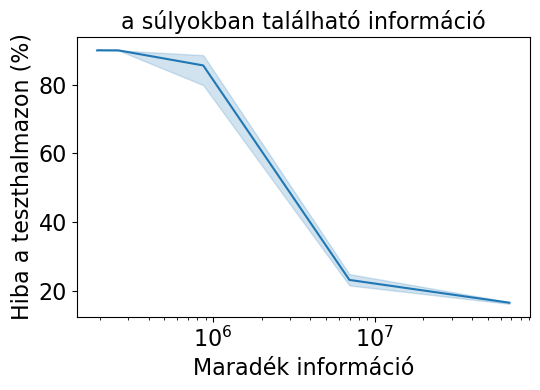

In [41]:
fig, ax = plt.subplots(figsize=(5.5, 4))
plot_info(ax,df,None,f'a súlyokban található információ') 

fig.tight_layout()
fig.savefig(f'data/lambda_plot{numf}.png', bbox_inches='tight')

# Adatok mentése

In [40]:
log_df = pd.DataFrame([log_dict])

In [41]:
log_df.to_csv(f'data_num/experimentsnumf{numf}_{alpha}.csv')
